# Cross-Validated Results

To assess the predictive performance of the techniques considered, a leave-one-year-out cross-validation scheme was applied for 2013-2019 period using the caret package for R. Only 10 representative sites per pollutant were selected for this cross-validation experiment due to the high computational cost, focusing on those sites with more available data, located in high population cities and providing a good representation of spatial variability. The air quality monitoring sites usen in the cross-validation experiment are detailed in `data/cross-validation/cv-sites.csv`.

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(ggplot2))

suppressMessages(library(openair))

In [2]:
# Cambiar la apariencia de las graficas en jupyter
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

## Studied Techniques

> **K-Nearest Neighbors (knn)**: a sensitive analysis of the K parameter has been performed for `k = 1:10`
> 
> **Random Forest (rf)**: A sensitivity analysis to the number of trees in the forest has been performed for `ntree = 10, 20, 30, 50, 100, 150, 200`
>
> **Multiple Linear Regression (lm)**: We have analysed the potential added value of incorporating predictor information from up to three days prior to the target day being predicted in our MLR models

The technique used is detail in `method` column with values `method = ("knn", "rf", "lm")`

## Empirical Quantile-Quantile Mapping

In order to minimize the bias-variance trade-off (Von Luxburg and Schölkepf, 2011; Friedman et al., 2017), an empirical quantile-quantile mapping (q-q mapping) post-correction has been applied to the three techniques described above using the R package downscaleR.

```R
downscaleR:::eqm(train.observation,
                 train.prediction,
                 test.prediction,
                 n.quantile=99,
                 precip=FALSE, pr.threshold=0,
                 extrapolation=""
                 ) 
```

The cross-validated results are saved in `data/cross-validation/results.rda` file, which contains the variable `cv.results` the following values:

> **metrics**: _data.frame_ with the different metrics used.
>    * RMSE: $\sqrt{\frac{\sum_i^N{({pred}_i - {obs}_i)^2}}{N}}$
>    * bias: $\frac{\overline{pred}}{\overline{obs}}$
>    * cor1: Pearson correlation between predictions and observations
>    * cor2: unseasonalised Pearson correlation between predictions and observations
>    * var.ratio: $\frac{var(pred)}{var(obs)}$
>
> **series**: _data.frame_ with observed air quality levels (`obs`), prediction by the model without q-q mapping (`pred`) and with q-q mapping post-correction (`pred.qq`)

Since some of the studied pollutants present a pronounced annual cycle, an unseasonalised correlation was also considered.

In [3]:
# Some notations for more beauty representation

pollut.notation <- c("no" = expression(NO),
                     "no2" = expression(NO[2]),
                     "o3" = expression(O[3]),
                     "pm10" = expression(PM10),
                     "pm2.5" = expression(PM2.5)
                    )
method.notation <- c("lm" = expression(MLR),
                     "rf" = expression(RF),
                     "knn" = expression(KNN)
                    )
Error.notation <- c("bias" = expression(paste("Bias", " ratio [-]")),
                    "cor1" = expression(paste("Correlation", " [-]")),
                    "cor2" = expression(paste("Unseasonalised", " correlation", " [-]")),
                    "RMSE" = expression(paste("RMSE [", mu, "g", m^-3, "]")),
                    "var.ratio" = expression(paste("Variance", " ratio [-]"))
                   )
site.notation <- c("es0118a" = "Madrid, Escuelas Aguirre",  # NO2, NO, O3, PM10, PM2.5 
                   "es1938a" = "Madrid, Castellana",  # PM2.5
                   "es1438a" = "Barcelona, l'Eixample",  # NO2, NO
                   "es1239a" = "Valencia, Pista de Silla",  # NO2, NO, O3, PM2.5
                   "es1181a" = "Valencia, Quart de Poblet",  # PM10
                   "es0890a" = "Sevilla, Torneo",  # NO2, NO, O3
                   "es1047a" = "Zaragoza, Roger de Flor",  # NO2, NO, O3, PM10
                   "es1137a" = "Vigo, Arenal (COIA)",  # NO2, NO, O3, PM10, PM2.5
                   "es0110a" = "Bilbao, Erandio",  # PM2.5
                   "es1244a" = "Bilbao, Mazarredo",  # NO2, NO, PM10
                   "es1632a" = "Valladolid, Vega Sicilia",  # O3, PM10
                   "es1631a" = "Valladolid, Arco de Ladrillo",  # NO2, NO, PM2.5
                   "es1580a" = "Santander, Centro",  # NO2, NO, PM10
                   "es1610a" = "Palma, Forens",  # NO2, NO, O3, PM10
                   "es1635a" = "Alicante, Alacant-El Pla",  # O3
                   "es1697a" = "San Sebastian, Avenida Tolosa",  # O3, PM2.5
                   "es1272a" = "Gijon, Constitucion",  # O3, PM10, PM2.5
                   "es1340a" = "Huelva, Pozo Dulce",  # PM10
                   "es1096a" = "Ourense, Gomez Franqueira",  # PM2.5
                   "es1492a" = "Vitoria, Tres Marzo"  # PM2.5
                   )

In [4]:
setwd("~/Repositories/AirQualityCOVID/")
load("data/cross-validation/results.rda")

In [5]:
pivot.metrics <- cv.results$metrics %>%
        pivot_longer(cols = 7:ncol(cv.results$metrics),
                     names_to = "Error", values_to = "Err.Val")

Select the model configurations to compare their cross-validated results

In [6]:
dat.df <- rbind(pivot.metrics %>%
                    filter(method == "lm",
                           days == 3,
                           qq.Mapping == "Yes",
                          ),
               pivot.metrics %>%
                    filter(method == "knn",
                           days == 0,
                           param == 10,
                           qq.Mapping == "Yes",
                          ),
                pivot.metrics %>%
                    filter(method == "rf",
                           days == 0,
                           param == 100,
                           qq.Mapping == "Yes"
                          )
               ) %>% arrange(variable, Error)

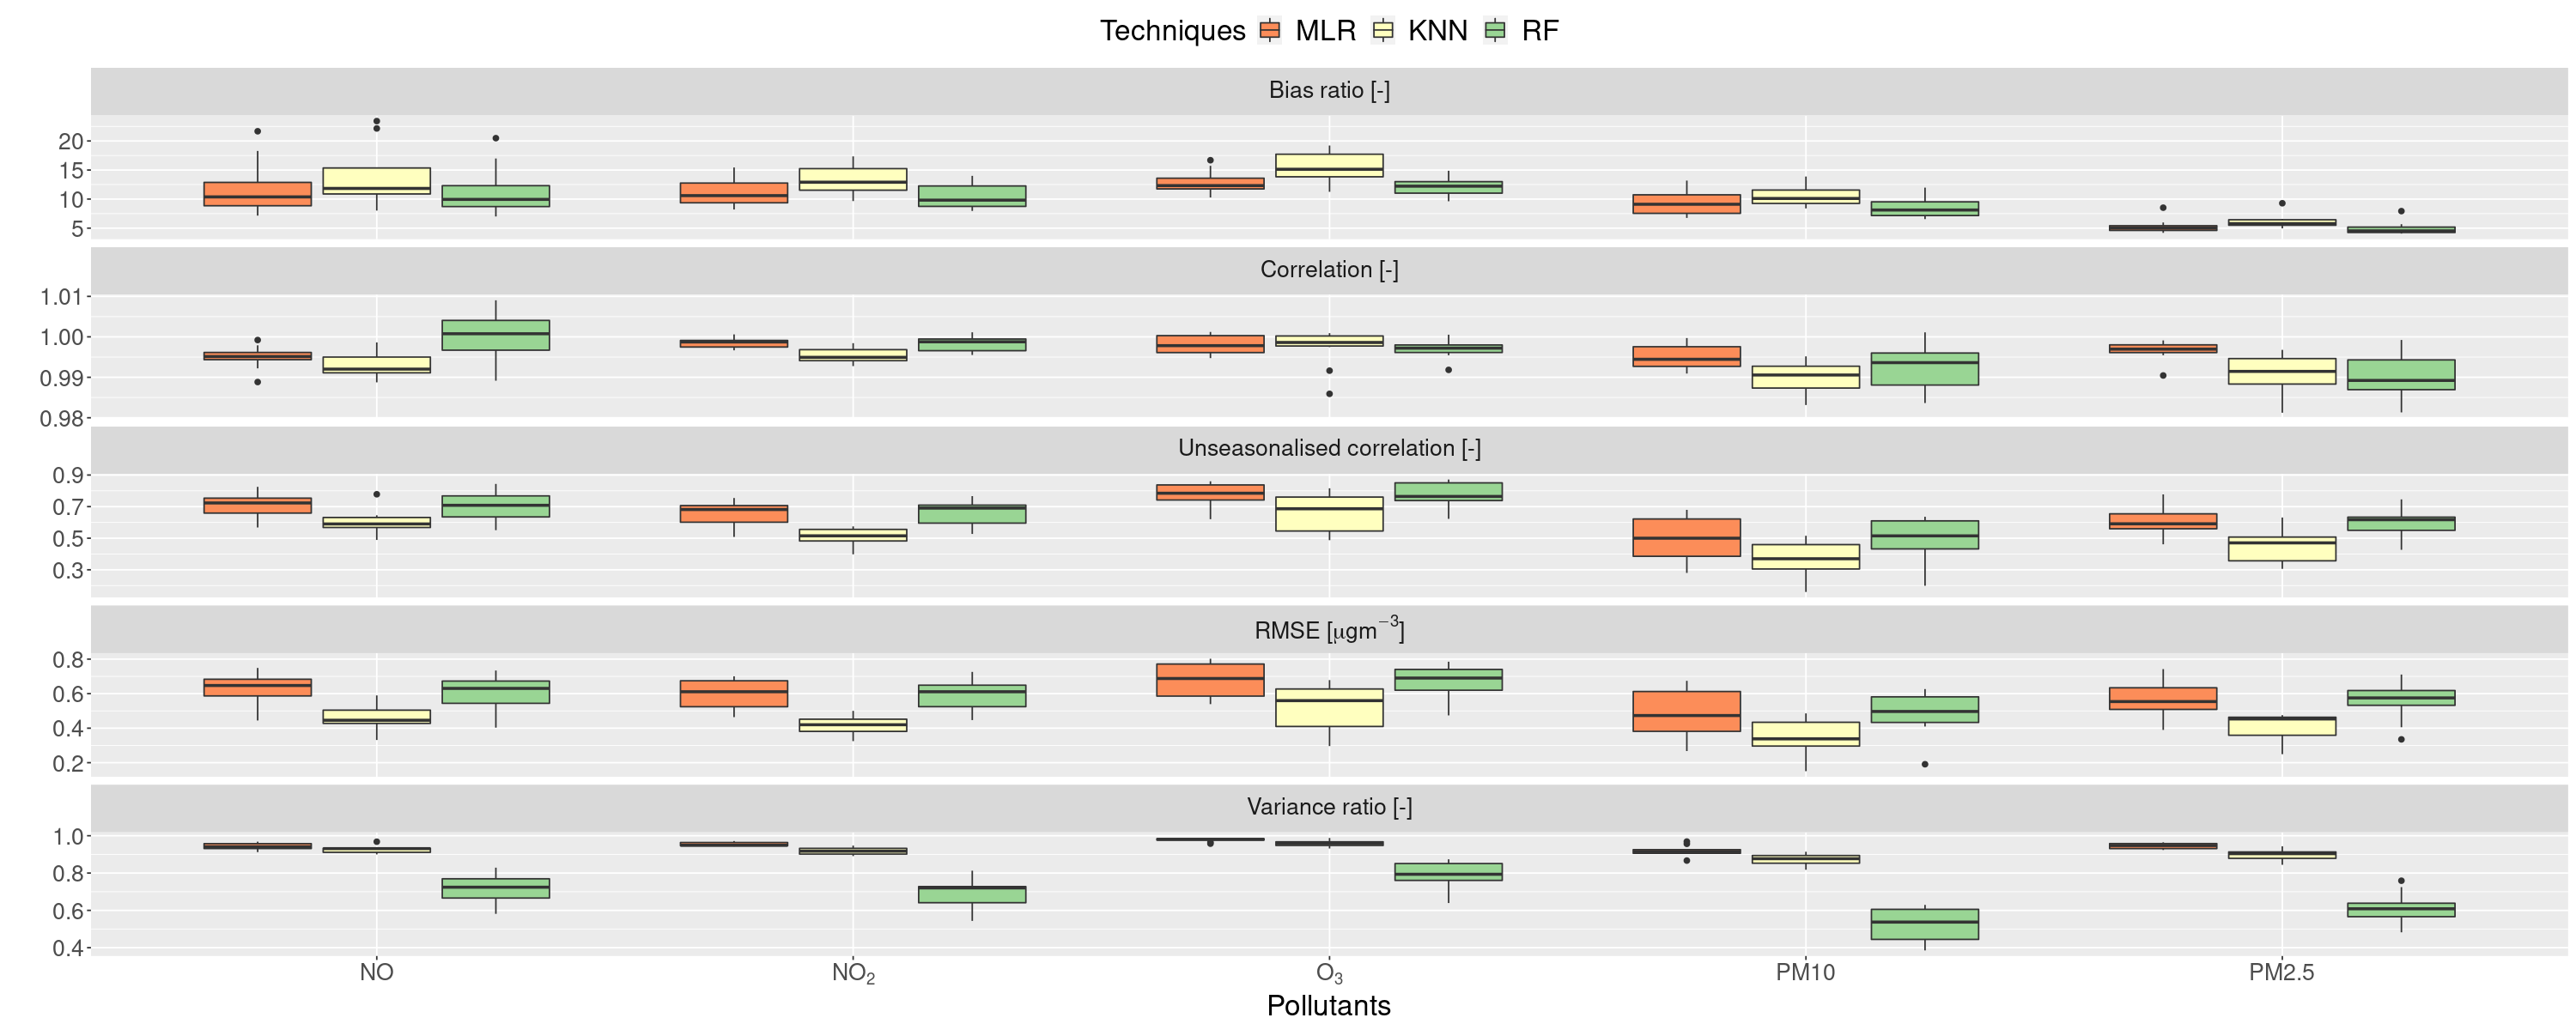

In [7]:
dat.df$Error <- factor(dat.df$Error, 
                       labels=Error.notation)

ggplot(data=dat.df) +
    geom_boxplot(aes(x=variable, 
                     y=Err.Val, 
                     fill=method, 
                     #color=qq.Mapping
                    )) +
    facet_wrap(~Error, 
               ncol=1, scale="free_y", 
               labeller = labeller(variable=label_parsed,
                                   Error=label_parsed)) +
    theme(legend.position="top",
          text = element_text(size=20),
          legend.text = element_text(size=20),
          legend.title = element_text(size=20),
         ) +
    scale_x_discrete(name="Pollutants", 
                     labels = pollut.notation
                    ) +
    scale_y_continuous(name="") +
    scale_fill_brewer(name="Techniques", 
                      labels = method.notation,
                      palette="Spectral") +
    scale_color_grey(name="",
                     labels = c("Yes" = "With q-q mapping", 
                                "No" = "Without q-q mapping"))

## Predicted Time Series

In [8]:
predict.df <- cv.results$series %>%
                filter(site %in% names(site.notation)[1],
                       variable %in% names(pollut.notation),
                      )

In [9]:
predict.df <- rbind(predict.df %>%
                        filter(method == "lm",
                               days == 3,
                              ))

In [10]:
predict.df$variable <- factor(predict.df$variable, 
                              labels=pollut.notation)

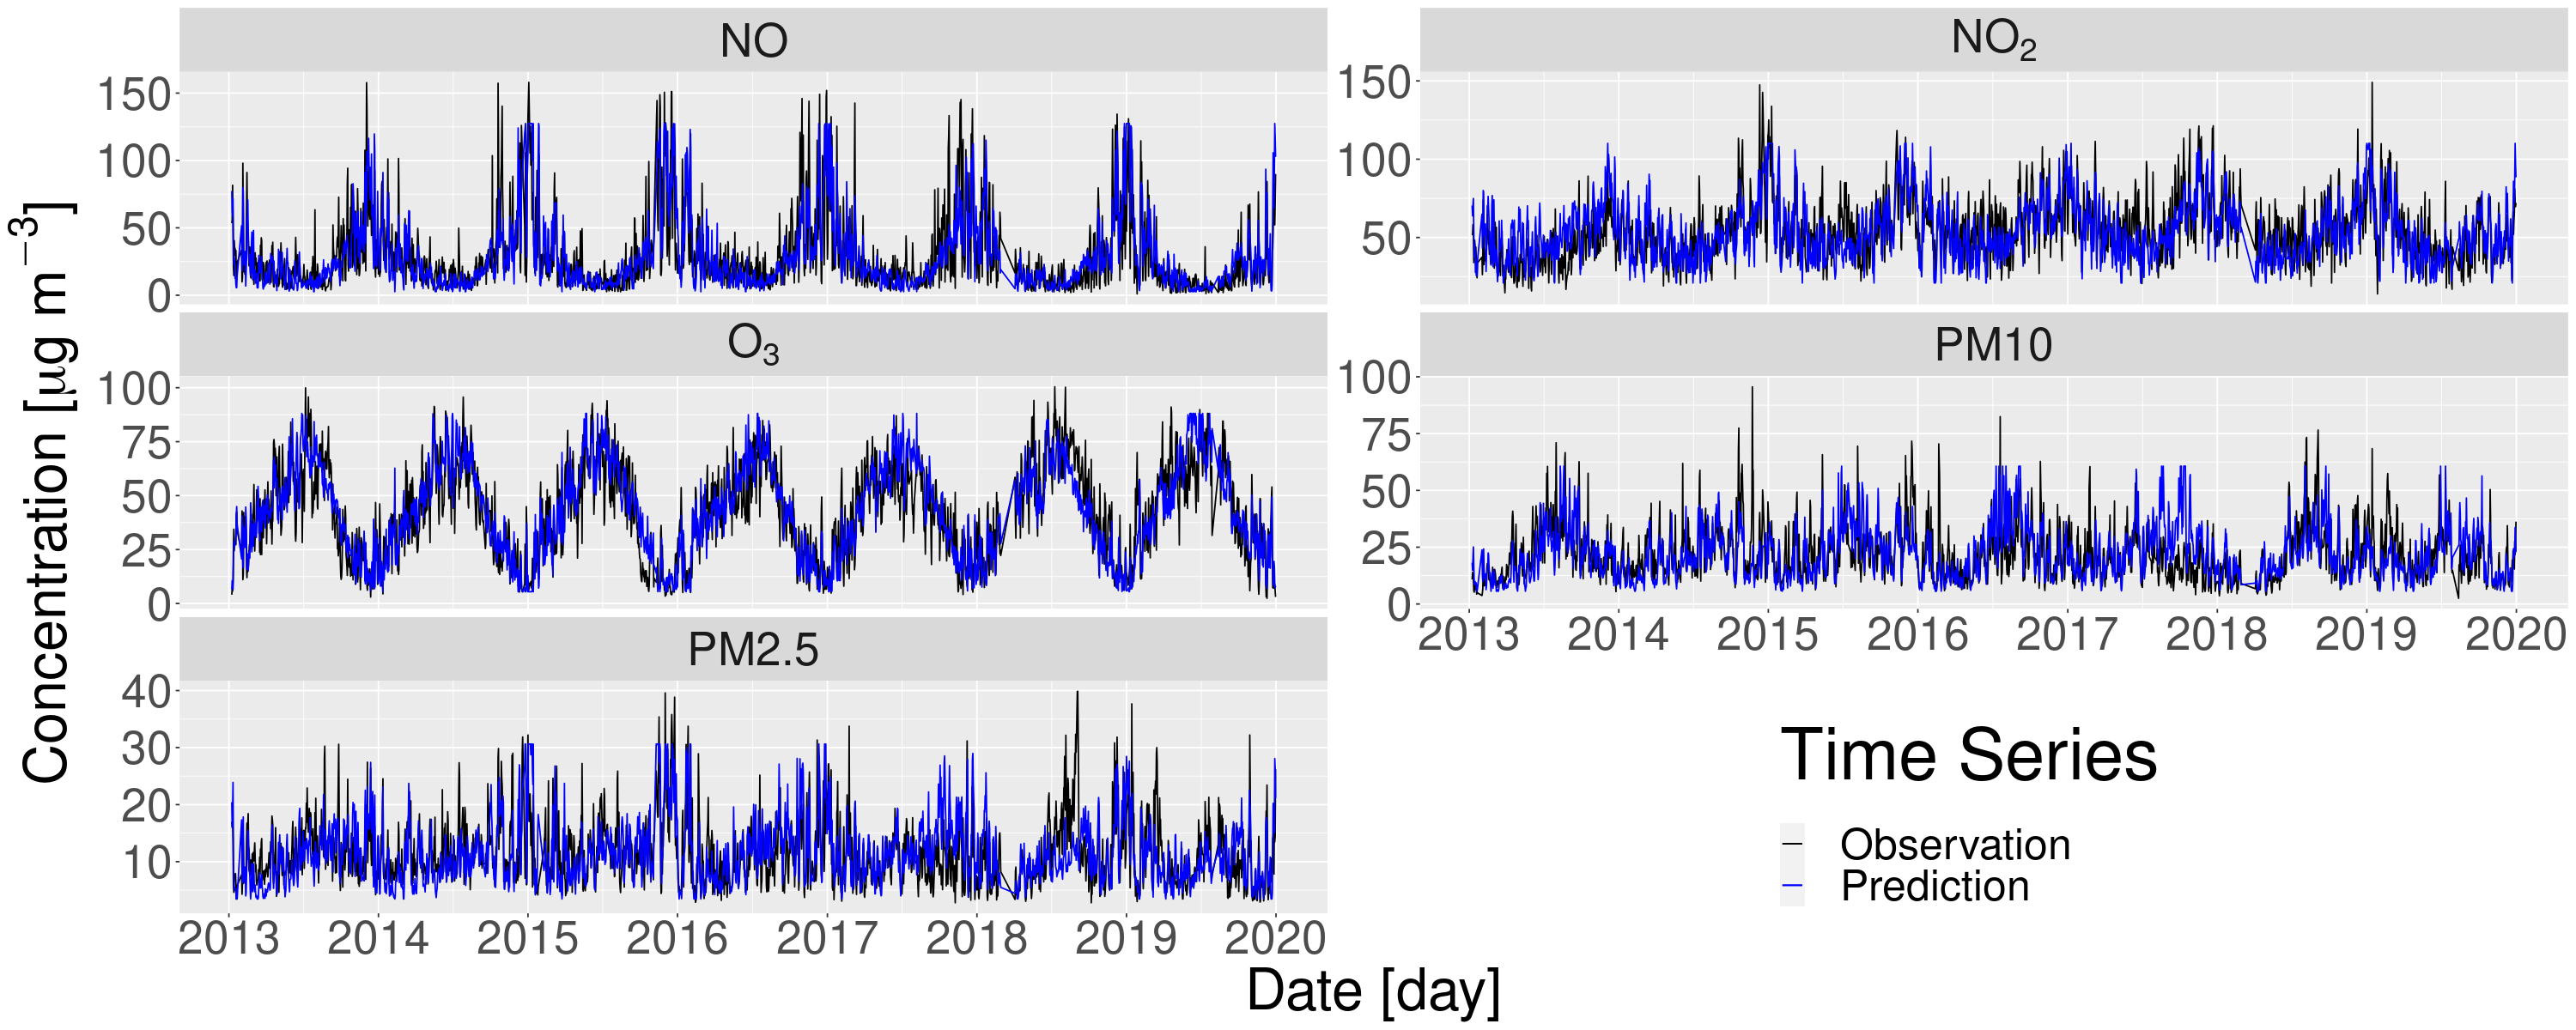

In [11]:
ggplot(data=predict.df %>%
           filter(lubridate::year(date) < 2020)) +
    geom_line(aes(x=date, y=obs, color = "Observation")) +
    geom_line(aes(x=date, y=pred.qq, color = "Prediction")) +
    facet_wrap(~variable, 
               ncol=2, scale="free_y", 
               labeller = labeller(variable=label_parsed)) +
    scale_color_manual(name="Time Series", 
                       values = c("Prediction" = "blue",
                                  "Observation" = "black")) +
    scale_x_date(name="Date [day]",
                 date_breaks = "1 year",
                 date_labels = "%Y") +
    scale_y_continuous(name=expression(paste("Concentration [", mu, "g ", m^-3, "]"))) +
    theme(legend.position=c(0.75,0.12),
          #legend.position="top",
          legend.text = element_text(size=30),
          legend.title = element_text(size=50),
          text = element_text(size=40),
         )

## Q-Q Mapping PDF Correction

An example of the q-q mapping correction for the MLR predictions of the Escuelas Aguirre site, Madrid, is shown

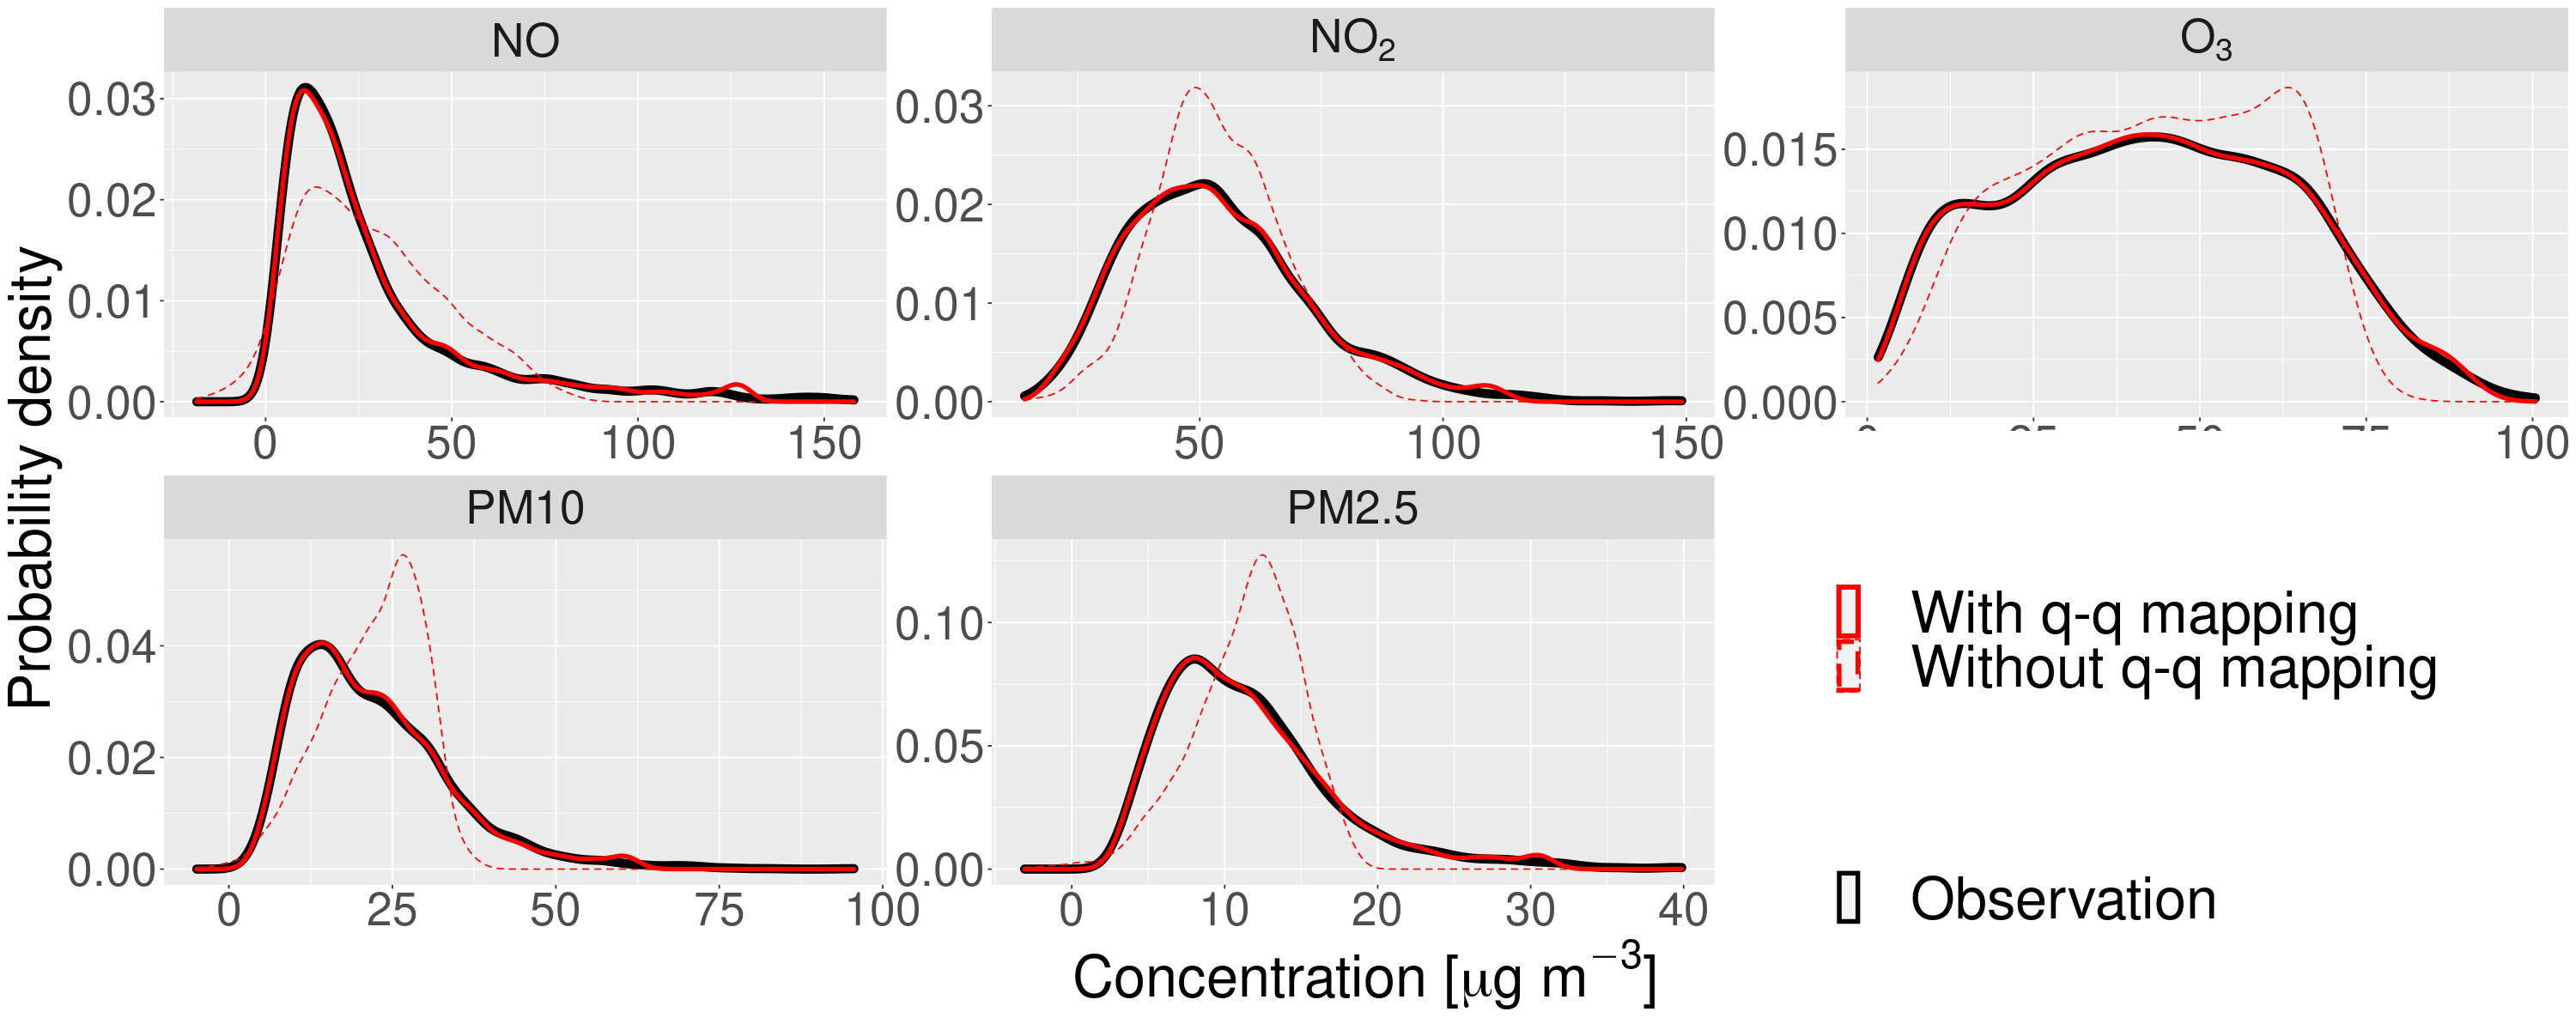

In [12]:
ggplot(data=predict.df) +
    scale_linetype_manual(name="",
                          values = c("With q-q mapping" = "solid", 
                                     "Without q-q mapping"="dashed")) +
    scale_color_manual(name="",
                       values = c("Observation"="black")) +
    geom_density(aes(x=obs, color="Observation"), size=3) +
    geom_density(aes(x=pred.qq,
                     #color=method,
                     linetype="With q-q mapping"),
                 color="red", 
                 size=1.5) +
    geom_density(aes(x=pred,
                     #color=method,
                     linetype="Without q-q mapping"),
                 color="red", 
                 size=0.5) +
    facet_wrap(~variable, 
               ncol = 3, scale="free",
               labeller = labeller(variable=label_parsed)) +
    scale_x_continuous(name=expression(paste("Concentration [", mu, "g ", m^-3, "]"))) +
    scale_y_continuous(name="Probability density") +
    theme(legend.position=c(0.82,0.25),
          text = element_text(size=40),
          legend.text = element_text(size=40),
          legend.title = element_text(size=70),
         )